<p align="center">
  <a href="url"><img src="https://images.unsplash.com/photo-1507720708252-1ddeb1dbff34?ixlib=rb-1.2.1&auto=format&fit=crop&w=1668&q=80" align="middle" height="383" width="640" ></a>
</p>

# Bagaimana Membuat Fully-Connected Image Classifier


Di dalam tutorial, kamu akan melatih sebuah fully-connected neural network untuk melakukan image classification bunga dandelion dan rumput. KIta akan menggunakan Framework Deep Learning TensorFlow untuk membuat neural network dan training/validation dataset. Pertama, silahkan download training and validation data.


### Building the Image Dataset

Codingan Python ini menggunakan OS library untuk melakukan Operating System libraries, memberikan access ke file system dan zipfile library untuk unzip datanya.

In [1]:
#Import Library OS/Zipfile
import os
import zipfile

local_zip = 'train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
local_zip = 'valid.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Isi dari .zip di extract ke directory `/tmp/train`, dimana setiap folder berisi subfolder dengan nama `dandelion` dan `rumput`.

Kita menggunakan [ImageGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class untuk membuat secara otomatis dataset train dari directory ini dengan menggunakan subdirectory untuk setiap kelasnya.

Menentukan setiap subdirectory :

In [2]:
# Directory with our training dandelion pictures
train_dandelion_dir = os.path.join('/tmp/train/dandelion')

# Directory with our training grass pictures
train_grass_dir = os.path.join('/tmp/train/grass')

# Directory with our validation dandelion pictures
valid_dandelion_dir = os.path.join('/tmp/valid/dandelion')

# Directory with our validation grass pictures
valid_grass_dir = os.path.join('/tmp/valid/grass')

Melihat seperti apa nama file di training directory `dandelion` dan `rumput` :

In [3]:
train_dandelion_names = os.listdir(train_dandelion_dir)
print(train_dandelion_names[:10])

train_grass_names = os.listdir(train_grass_dir)
print(train_grass_names[:10])

validation_dandelion_hames = os.listdir(valid_dandelion_dir)
print(validation_dandelion_hames[:10])

validation_grass_names = os.listdir(valid_grass_dir)
print(validation_grass_names[:10])

['00000483.jpg', '00000393.jpg', '00000034.jpg', '00000044.jpg', '00000074.jpg', '00000415.jpg', '00000206.jpg', '00000365.jpg', '00000420.jpg', '00000162.jpg']
['00000483.jpg', '00000393.jpg', '00000034.jpg', '00000044.jpg', '00000074.jpg', '00000415.jpg', '00000478.jpg', '00000206.jpg', '00000420.jpg', '00000123.jpg']
['00000044.jpg', '00000042.jpg', '00000088.jpg', '00000012.jpg', '00000016.jpg', '00000000.jpg', '00000023.jpg', '00000081.jpg', '00000004.jpg', '00000059.jpg']
['00000044.jpg', '00000008.jpg', '00000023.jpg', '00000004.jpg', '00000022.jpg', '00000027.jpg', '00000059.jpg', '00000005.jpg', '00000050.jpg', '00000028.jpg']


Mencari informasi berapa total images dari dandelion dan rumput di directory :

In [4]:
print('total training dandelion images:', len(os.listdir(train_dandelion_dir)))
print('total training rumput images:', len(os.listdir(train_grass_dir)))
print('total validation dandelion images:', len(os.listdir(valid_dandelion_dir)))
print('total validation rumput images:', len(os.listdir(valid_grass_dir)))

total training dandelion images: 451
total training rumput images: 443
total validation dandelion images: 65
total validation rumput images: 43


Melihat beberapa pictures untuk mendapatkan sense lebih baik Seperti apa.
Hal pertama yang dilakukan adalah melakukan konfigurasi matplot parameters:

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Menampilkan 8 batch dari 8 dandelion and 8 rumput pictures. Kamu bisa melakukan rerun cell kembali untuk melihat fresh batch setiap waktu:

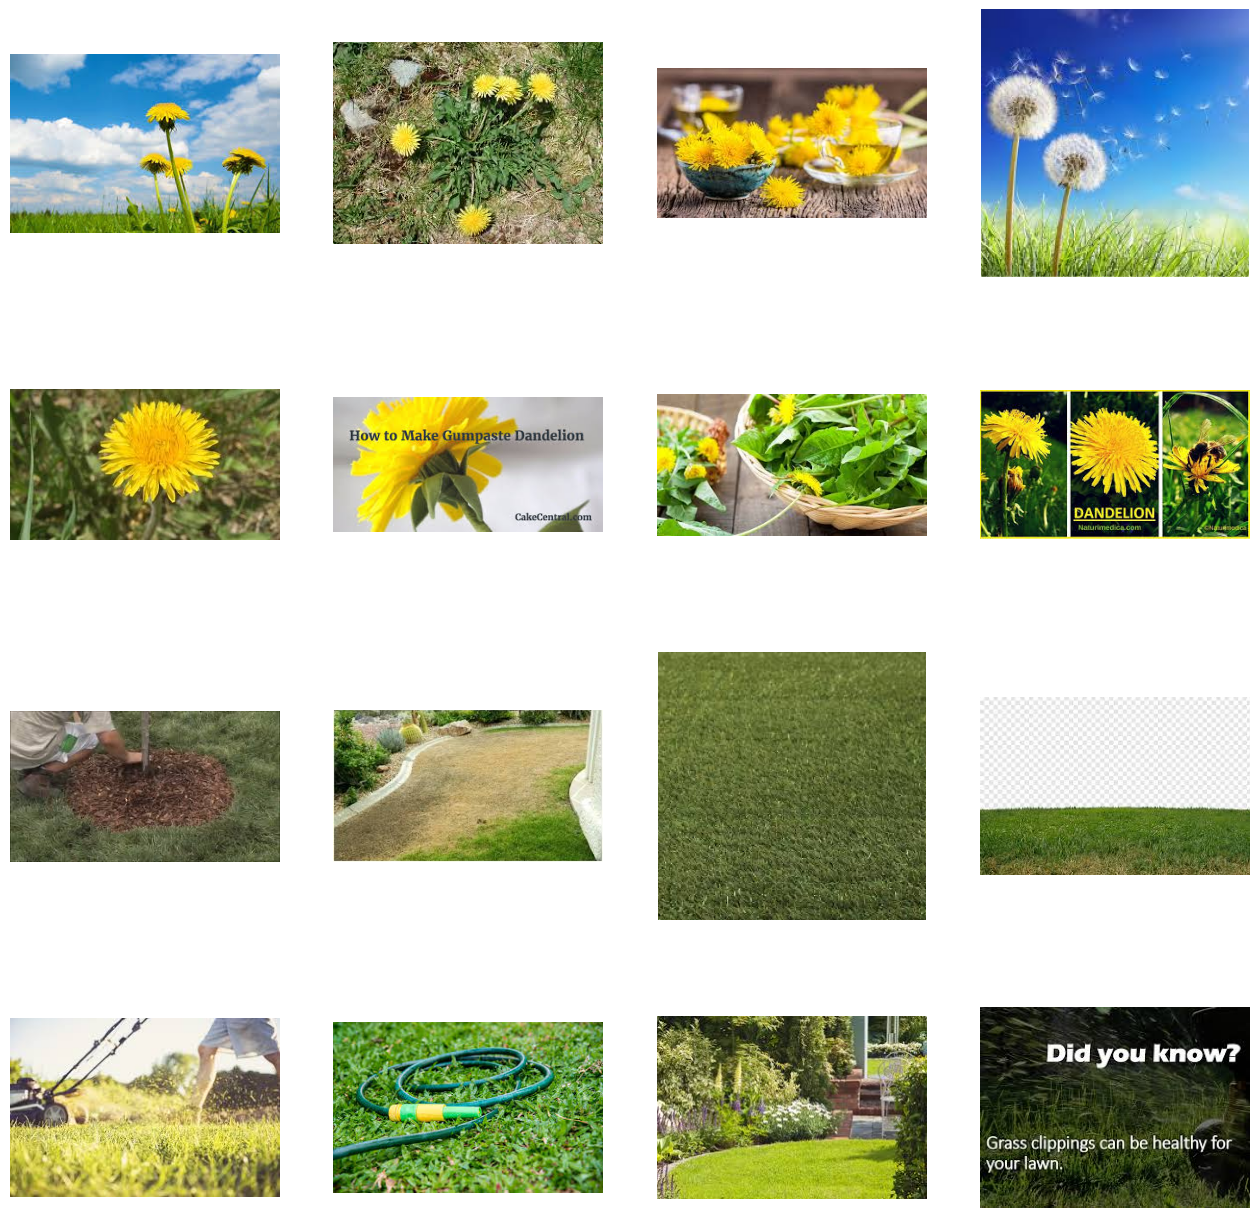

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_dandelion_pic = [os.path.join(train_dandelion_dir, fname)
                for fname in train_dandelion_names[pic_index-8:pic_index]]
next_grass_pic = [os.path.join(train_grass_dir, fname)
                for fname in train_grass_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_dandelion_pic + next_grass_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


#### Data Preprocessing

Menggunakan `keras.preprocessing.image.ImageDataGenerator` class untuk membuat  train and validation dataset dan normalize data.
Sangat penting untuk melakukan normalize data karena data akan diproses oleh CNN untuk improve performance secara keseluruhan. Disini kita akan menggunakan `rescale` parameter untuk scale our image pixel values dari [0, 255] ke [0,1].

Disetiap generator, kita menentukan source directory dari images, classes, input image size, batch size (seberapa banyak images yang akan diproses), dan class mode.

# Train with KAN Conv

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import math
from torchsummary import summary

## 1. Definisi KANLinear
  - Definisi ini mengikuti sumber yang diberikan dan digunakan dalam model CNNKAN.

In [8]:
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3, scale_noise=0.1, scale_base=1.0, scale_spline=1.0, enable_standalone_scale_spline=True, base_activation=nn.SiLU, grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous())
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) * self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise))
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, : -(k + 1)]) / (grid[:, k:-1] - grid[:, : -(k + 1)]) * bases[:, :, :-1]) + ((grid[:, k + 1 :] - x) / (grid[:, k + 1 :] - grid[:, 1:(-k)]) * bases[:, :, 1:])
        assert bases.size() == (x.size(0), self.in_features, self.grid_size + self.spline_order)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)
        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1), self.scaled_spline_weight.view(self.out_features, -1))
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)
        splines = self.b_splines(x).permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff).permute(1, 0, 2)
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[torch.linspace(0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device)]
        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (torch.arange(self.grid_size + 1, dtype=torch.float32, device=x.device).unsqueeze(1) * uniform_step + x_sorted[0] - margin)
        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.cat([grid[:1] - uniform_step * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1), grid, grid[-1:] + uniform_step * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1)], dim=0)
        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return regularize_activation * regularization_loss_activation + regularize_entropy * regularization_loss_entropy


## 2. Model CNNKAN
  - Model CNNKAN disesuaikan untuk ukuran gambar 200x200.

In [9]:
class CNNKAN(nn.Module):
    def __init__(self):
        super(CNNKAN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.kan1 = KANLinear(64 * 50 * 50, 256)  # Adjusted for input size 200x200
        self.kan2 = KANLinear(256, 1)  # Output layer for binary classification

    def forward(self, x):
        x = F.selu(self.conv1(x))
        x = self.pool1(x)
        x = F.selu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.kan1(x)
        x = torch.sigmoid(self.kan2(x))  # Sigmoid for binary classification
        return x


## 4. Menggunakan ImageDataGenerator untuk Dataset Dandelion dan Grass
  - Dataset ini disiapkan menggunakan ImageDataGenerator dari Keras dan kemudian dikonversi menjadi PyTorch Dataset.

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Directory paths
train_dir = '/tmp/train'
val_dir = '/tmp/valid'

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# Create the data loaders with smaller batch size
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


## 5. Training dan Evaluasi Model
  - Bagian ini mendefinisikan loop training dan evaluasi model. Clear Gradients dan Kosongkan Cache

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNNKAN().to(device)
print(model)
summary(model, input_size=(3, 200, 200))

# Print model parameter details
def print_parameter_details(model):
    for name, param in model.named_parameters():
        print(f"{name}: {param.size()} {'requires_grad' if param.requires_grad else 'frozen'}")

print_parameter_details(model)

# Visualize KAN parameters
def visualize_kan_parameters(kan_layer, layer_name):
    base_weights = kan_layer.base_weight.data.cpu().numpy()
    plt.hist(base_weights.ravel(), bins=50)
    plt.title(f"Distribution of Base Weights - {layer_name}")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.show()
    if hasattr(kan_layer, 'spline_weight'):
        spline_weights = kan_layer.spline_weight.data.cpu().numpy()
        plt.hist(spline_weights.ravel(), bins=50)
        plt.title(f"Distribution of Spline Weights - {layer_name}")
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")
        plt.show()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

# Training function
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(inputs)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

        # Clear CUDA cache
        torch.cuda.empty_cache()

    return running_loss / len(train_loader)

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()

            # Clear CUDA cache
            torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy

# Input jumlah epoch
jumlah_epoch = int(input("Masukkan jumlah epoch: "))
for epoch in range(jumlah_epoch):
    train_loss = train(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{jumlah_epoch}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%")

# Save model weights
torch.save(model.state_dict(), 'model_weights_KAN.pth')

# Evaluate model on validation set
def test(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()

            # Clear CUDA cache
            torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    return accuracy

accuracy = test(model, val_loader, device)
print(f'Validation Accuracy: {accuracy:.2f}%')

CNNKAN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (kan1): KANLinear(
    (base_activation): SiLU()
  )
  (kan2): KANLinear(
    (base_activation): SiLU()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             896
         MaxPool2d-2         [-1, 32, 100, 100]               0
            Conv2d-3         [-1, 64, 100, 100]          18,496
         MaxPool2d-4           [-1, 64, 50, 50]               0
              SiLU-5               [-1, 160000]               0
         KANLinear-6                  [-1, 256]               0
              SiLU-7                  [-1,

## 3. Evaluasi Model pada Data Test

In [12]:
"""
# Create the test dataset and loader
test_dir = '/tmp/test'
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()

            # Kosongkan cache CUDA
            torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    return accuracy

accuracy = test(model, test_loader, device)
print(f'Test Accuracy: {accuracy}%')
"""

"\n# Create the test dataset and loader\ntest_dir = '/tmp/test'\ntest_dataset = datasets.ImageFolder(root=test_dir, transform=transform)\ntest_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)\n\ndef test(model, test_loader, device):\n    model.eval()\n    correct = 0\n    total = 0\n    with torch.no_grad():\n        for inputs, labels in test_loader:\n            inputs, labels = inputs.to(device), labels.to(device)\n            outputs = model(inputs)\n            predicted = (outputs > 0.5).float()\n            total += labels.size(0)\n            correct += (predicted.squeeze() == labels).sum().item()\n\n            # Kosongkan cache CUDA\n            torch.cuda.empty_cache()\n\n    accuracy = 100 * correct / total\n    return accuracy\n\naccuracy = test(model, test_loader, device)\nprint(f'Test Accuracy: {accuracy}%')\n"

# Plot ROC Curve

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch

# Function to calculate predictions and true labels
def get_predictions_and_labels(model, val_loader, device):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.array(preds), np.array(true_labels)

# Function to plot ROC Curve
def plot_roc_curve(true_labels, preds):
    fpr, tpr, _ = roc_curve(true_labels, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Assuming you have your model, val_loader, and device already defined
# Example usage
preds, true_labels = get_predictions_and_labels(model, val_loader, device)
plot_roc_curve(true_labels, preds)


# Model Prediction

In [14]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor()
])

# Upload images
uploaded = files.upload()

# Predict and display images
for fn in uploaded.keys():
    # Load and preprocess image
    path = fn
    img = Image.open(path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        prob = torch.sigmoid(output).item()

    # Display image
    plt.imshow(np.array(img))
    plt.axis('off')
    plt.show()

    # Print prediction
    print(f"Prediksi untuk {fn}: {prob:.4f}")
    if prob < 0.5:
        print(f"{fn} ini adalah bunga dandelion")
    else:
        print(f"{fn} ini adalah rumput")


KeyboardInterrupt: 

## Clean Up
Run the following cell to terminate the kernel and free memory resources:

In [ ]:
# import os, signal
# os.kill(os.getpid(), signal.SIGKILL)